##Notebook 4 : Inference & Evaluation

This series of notebooks demonstrates a comparative approach to fake news detection using natural language processing (NLP) techniques. We will use a dataset from Kaggle containing labeled news articles as real or fake.



### Ensuring TensorFlow Version 2.15
This code installs TensorFlow version 2.15.0 and tensorflow-text 2.15.0 using pip. This specific version might be required for compatibility with the code in this notebook. Errors during installation can be ignored.

In [1]:
!pip -q install tensorflow==2.15.0
!pip -q install tensorflow-text==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.67 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.9 MB/s eta 0:00:00

### Importing Necessary Libraries
This code imports the required libraries for data processing, model inference and visualization.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gdown

import re
import nltk
import json
import pandas as pd

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Downloading the Preprocessed Dataset
This Code downloads the Models & Tokenizers using `git clone`. The files are  assumed to be created in a previous notebook and are stored in a github repository.

In [3]:
!git clone https://github.com/starryendymion/ML-GP1-Monsoon-2024-SOEJNU
%cd 'ML-GP1-Monsoon-2024-SOEJNU'

Cloning into 'ML-GP1-Monsoon-2024-SOEJNU'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 16 (from 1)
Receiving objects: 100% (19/19), 91.95 MiB | 23.11 MiB/s, done.
/content/ML-GP1-Monsoon-2024-SOEJNU


### Loading Models and Tokenizer

This cell loads the pre-trained ALBERT and Bidirectional LSTM models along with the tokenizer from the downloaded files.

In [4]:
custom_objects = {'KerasLayer': hub.KerasLayer}
albert_model=tf.keras.models.load_model("model-files-case2/finetuned-albert_model.h5",custom_objects=custom_objects)

with open('model-files-case1/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

lstm_model = tf.keras.models.load_model('model-files-case1/bidirectional-lstm-model.h5')

### Importing Utility Functions

This cell imports custom utility functions from the `utils.py` file, which likely contains helper functions for evaluation and other tasks.

In [7]:
from utils import*

### Downloading and Preparing Datasets

This cell downloads three fake news datasets from Kaggle using the `kagglehub` library and prepares them for evaluation by:
1. Downloading and moving datasets to '/content/datasets'.
2. Loading datasets into pandas DataFrames.
3. Dropping duplicates and null rows.
4. Combining title and text columns for some datasets.
5. Creating feature and label lists for each dataset.

In [8]:
import kagglehub
import os

# Create the target directory if it doesn't already exist
os.makedirs('/content/datasets', exist_ok=True)

# List of dataset names
datasets = [
    "saurabhshahane/fake-news-classification",
    "hassanamin/textdb3",
    "vishakhdapat/fake-news-detection"
]

# Download and extract each dataset using kagglehub
for dataset in datasets:
    path = kagglehub.dataset_download(dataset)
    # Move each downloaded dataset to the /content/datasets folder
    !mv {path}/* /content/datasets/
    print(f"Downloaded and moved {dataset} to /content/datasets")

print("All datasets downloaded and stored in /content/datasets")

100%|██████████| 92.1M/92.1M [00:01<00:00, 58.5MB/s]

Extracting files...


Downloaded and moved saurabhshahane/fake-news-classification to /content/datasets


100%|██████████| 11.5M/11.5M [00:00<00:00, 66.2MB/s]

Extracting files...


Downloaded and moved hassanamin/textdb3 to /content/datasets


100%|██████████| 9.37M/9.37M [00:00<00:00, 44.8MB/s]

Extracting files...


Downloaded and moved vishakhdapat/fake-news-detection to /content/datasets
All datasets downloaded and stored in /content/datasets


In [9]:
# Paths to datasets
path1 = "/content/datasets/WELFake_Dataset.csv"
path2 = "/content/datasets/fake_or_real_news.csv"
path3 = "/content/datasets/fake_and_real_news.csv"

# Load datasets and drop duplicates and null rows
d1 = pd.read_csv(path1).dropna().drop_duplicates()
d2 = pd.read_csv(path2).dropna().drop_duplicates()
d3 = pd.read_csv(path3).dropna().drop_duplicates()

# Process d1
feature1 = [(str(title) + "<BREAK>" + str(text)) for title, text in zip(d1['title'], d1['text'])]
label1 = d1['label'].tolist()

# Process d2
feature2 = [(str(title) + "<BREAK>" + str(text)) for title, text in zip(d2['title'], d2['text'])]
label2 = [1 if label == "REAL" else 0 for label in d2['label']]

# Process d3
feature3 = d3['Text'].tolist()
label3 = [1 if label == "Real" else 0 for label in d3['label']]

# Display sizes of the lists
print("feature1:", len(feature1), "label1:", len(label1))
print("feature2:", len(feature2), "label2:", len(label2))
print("feature3:", len(feature3), "label3:", len(label3))

feature1: 71537 label1: 71537
feature2: 6335 label2: 6335
feature3: 9865 label3: 9865


In [10]:
import random

def sample_data(feature1, label1, feature2, label2, feature3, label3, sample_size):
    # Define a helper function to filter lists based on feature length
    def filter_long_features(features, labels, max_len=2500):
        filtered_features = []
        filtered_labels = []
        for feature, label in zip(features, labels):
            if len(feature) <= max_len:
                filtered_features.append(feature)
                filtered_labels.append(label)
        return filtered_features, filtered_labels

    # Filter each feature-label pair
    feature1, label1 = filter_long_features(feature1, label1)
    feature2, label2 = filter_long_features(feature2, label2)
    feature3, label3 = filter_long_features(feature3, label3)

    # Calculate the sample size per feature/label list
    sample_per_list = sample_size // 3  # Divide total samples equally among the 3 lists
    sample_per_label = sample_per_list // 2  # Divide further between label 0 and label 1

    def sample_from_list(features, labels, sample_per_label):
        # Separate indices based on label
        idx_label_0 = [i for i, label in enumerate(labels) if label == 0]
        idx_label_1 = [i for i, label in enumerate(labels) if label == 1]

        # Randomly sample the required number of indices for each label
        sampled_idx_0 = random.sample(idx_label_0, min(sample_per_label, len(idx_label_0)))
        sampled_idx_1 = random.sample(idx_label_1, min(sample_per_label, len(idx_label_1)))

        # Gather the samples using the indices
        sampled_features = [features[i] for i in sampled_idx_0 + sampled_idx_1]
        sampled_labels = [labels[i] for i in sampled_idx_0 + sampled_idx_1]

        return sampled_features, sampled_labels

    # Sample from each feature-label pair
    sampled_features_1, sampled_labels_1 = sample_from_list(feature1, label1, sample_per_label)
    sampled_features_2, sampled_labels_2 = sample_from_list(feature2, label2, sample_per_label)
    sampled_features_3, sampled_labels_3 = sample_from_list(feature3, label3, sample_per_label)

    # Combine all sampled features and labels from each list
    combined_features = sampled_features_1 + sampled_features_2 + sampled_features_3
    combined_labels = sampled_labels_1 + sampled_labels_2 + sampled_labels_3

    return combined_features, combined_labels



### Sampling and Evaluating

This cell defines a function `sample_data` to sample data from the three datasets and ensures that the sampled data has a balanced representation of real and fake news. After sampling, it evaluates the performance of the loaded models (ALBERT and LSTM) using the sampled data and the utility functions from `utils.py`.

1/1 [==============================] - 0s 40ms/step


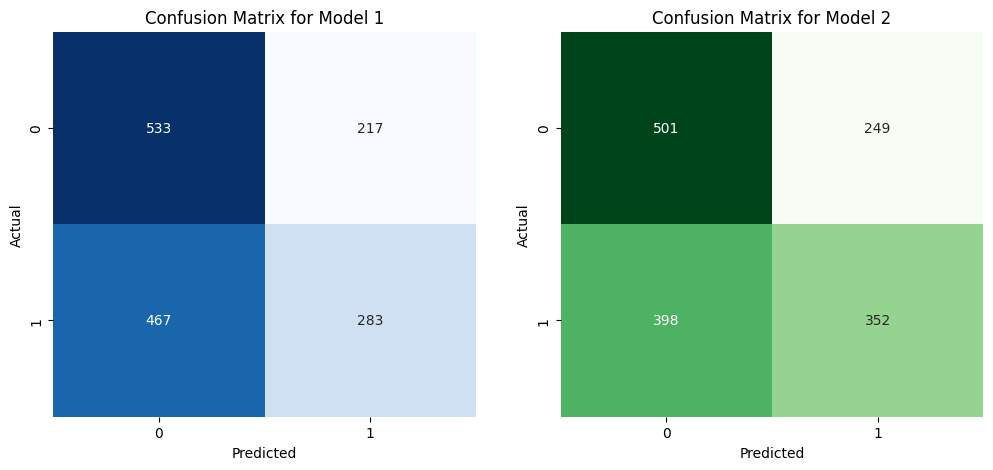

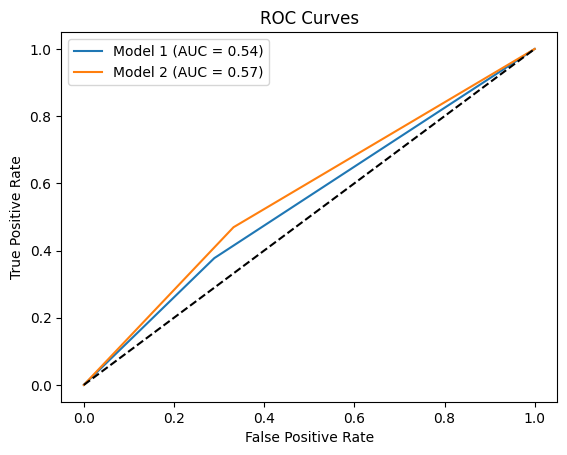

Model 1 Evaluation Metrics:
Accuracy: 0.544
Precision: 0.566
Recall: 0.37733333333333335
F1 Score: 0.4528
ROC AUC Score: 0.544

Model 2 Evaluation Metrics:
Accuracy: 0.5686666666666667
Precision: 0.5856905158069884
Recall: 0.4693333333333333
F1 Score: 0.5210954848260547
ROC AUC Score: 0.5686666666666667


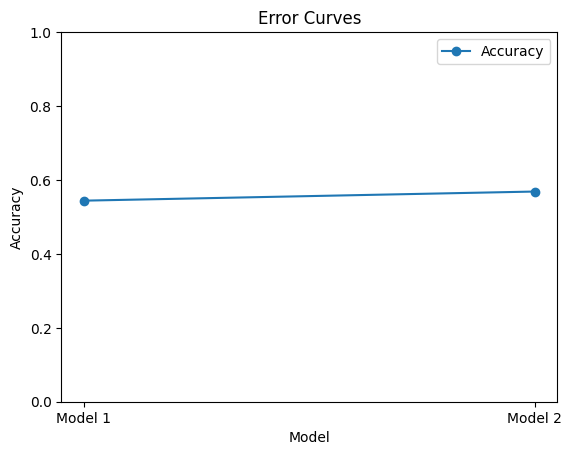

In [11]:
sampled_features, sampled_labels = sample_data(feature1, label1, feature2, label2, feature3, label3, sample_size=1500)
evaluate(sampled_features,sampled_labels,tokenizer,lstm_model,albert_model)